# **파라미터와 net은 각자 수정하기!**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [5]:
#계속 같은 결과 나오도록 하는 코드 (https://hoya012.github.io/blog/reproducible_pytorch/)
#random_seed 숫자만 바꿔가면서 코드 실행하면돼!
import random

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True  #계산속도 느려질 수 있대 너무 느려지면 주석처리하기
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
# paths for (labeled) training & validation data.
train_path = '/content/drive/MyDrive/FashionClassification/Train/'
valid_path = '/content/drive/MyDrive/FashionClassification/Validation/'
aug_path = '/content/drive/MyDrive/FashionClassification/Aug2/'

In [7]:
# prepare training data set
classes = ['Resort', 'Retro', 'Sporty']

data =[]
label =[]

## i : Integer representation for each classes (Resort/Retro/Sporty -> 0/1/2)
for i, d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f,'r')
        img = img.resize((150,150)) #(150,150)
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)

for i, d in enumerate(classes):
    files = os.listdir(aug_path+'/'+d)
    
    for f in files:
        img = Image.open(aug_path+'/'+d+'/'+f,'r')
        img = img.resize((150,150)) #(150,150)
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)     
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [8]:
data.shape, label.shape  # check

((21594, 3, 150, 150), (21594,))

In [9]:
# prepare validation data set
data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+'/'+d)
    
    for f in files:
        img = Image.open(valid_path+'/'+d+'/'+f,'r')
        img = img.resize((150,150))
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1)) # (150,150,3) --> (3,150,150)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [10]:
data.shape, label.shape  # check

((1800, 3, 150, 150), (1800,))

In [11]:
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
        )

        self.avg_pool=nn.AvgPool2d(7)
        self.fc = nn.Linear(2048,3)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


model = Net().to(DEVICE)
model # print network

Net(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AvgPool

In [12]:
from torchsummary import summary
summary(model, (3, 150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             448
              ReLU-2         [-1, 16, 148, 148]               0
            Conv2d-3         [-1, 16, 146, 146]           2,320
              ReLU-4         [-1, 16, 146, 146]               0
         MaxPool2d-5           [-1, 16, 72, 72]               0
            Conv2d-6           [-1, 32, 70, 70]           4,640
              ReLU-7           [-1, 32, 70, 70]               0
            Conv2d-8           [-1, 32, 68, 68]           9,248
              ReLU-9           [-1, 32, 68, 68]               0
        MaxPool2d-10           [-1, 32, 33, 33]               0
           Conv2d-11           [-1, 64, 31, 31]          18,496
             ReLU-12           [-1, 64, 31, 31]               0
           Conv2d-13           [-1, 64, 29, 29]          36,928
             ReLU-14           [-1, 64,

In [13]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [14]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        # print('Valid_Prediction : {}'.format(pred))
        # print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /100
Train Accuracy : 49.48133740853941
Validation Accuracy : 54.388888888888886
Train Loss : 168.6150307059288
Validation Loss : 14.103268146514893
# Epoch : 1 /100
Train Accuracy : 56.10354728165231
Validation Accuracy : 58.666666666666664
Train Loss : 156.649374127388
Validation Loss : 13.401646435260773
# Epoch : 2 /100
Train Accuracy : 57.86792627581736
Validation Accuracy : 58.666666666666664
Train Loss : 150.68215554952621
Validation Loss : 12.85935789346695
# Epoch : 3 /100
Train Accuracy : 60.23895526535149
Validation Accuracy : 60.22222222222222
Train Loss : 145.23442178964615
Validation Loss : 12.742095530033112
# Epoch : 4 /100
Train Accuracy : 61.253125868296756
Validation Accuracy : 60.83333333333333
Train Loss : 141.62492829561234
Validation Loss : 12.695597171783447
# Epoch : 5 /100
Train Accuracy : 62.42474761507826
Validation Accuracy : 60.05555555555555
Train Loss : 137.60259824991226
Validation Loss : 12.22506046295166
# Epoch : 6 /100


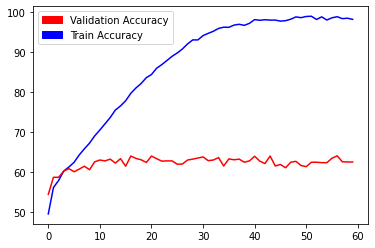

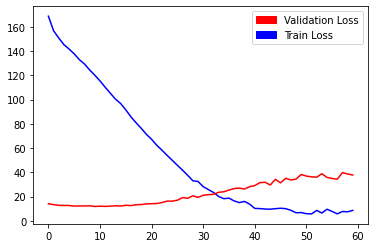

<All keys matched successfully>

In [15]:
# Learning
import copy

acc_t = []
acc_v = []

loss_train = []
loss_val = []

print('***START EPOCH***')
best_acc = 0.0  # beset accuracy 초기화
best_model_wts = copy.deepcopy(model.state_dict()) 

for epoch in range(60):
    print('# Epoch : {} /100'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    print('Train Loss : {}'.format(loss_t))
    print('Validation Loss : {}'.format(loss_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)
    loss_train.append(loss_t)
    loss_val.append(loss_v)

    if accuracy_v>best_acc:  # update best accuracy
      best_acc = accuracy_v
      best_model_wts = copy.deepcopy(model.state_dict())  # 가장 accuracy 높은 model 저장

plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Loss Graph
plt.plot(range(len(loss_train)), loss_train, 'b', range(len(loss_val)), loss_val, 'r')
blue_patch = mpatches.Patch(color='blue', label='Train Loss')
red_patch = mpatches.Patch(color='red', label='Validation Loss')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

model.load_state_dict(best_model_wts) # validation accuracy, 가장 높은 모델 저장

In [18]:
torch.save(model,'TeamB_x2')

In [16]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0       # 맞게 예측한 0 값으로 초기화
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
.05
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     # data, target DEVICE에 할당
            output = model(data)                                  # output 계산
            test_loss += criterion(output, target).item()         # loss 계산(총 loss 에 더해주기)
            pred = output.max(1, keepdim=True)[1]                 # 계산된 벡터값 중 가장 큰 값 가지는 class 예측
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy

In [19]:
model=torch.load('TeamB_x2')
#model.eval()
_, train_acc = evaluate(model, train_loader)
_, val_acc = evaluate(model, valid_loader)

# prit saved model's train and validation accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Validation Accuracy: {:.4f}'.format(val_acc))

Train Accuracy: 99.1989
Validation Accuracy: 64.0556


In [ ]:
from sklearn.metrics import classification_report
def prediction(model, data_loader):
    model.eval()
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
      for i, (data, label) in enumerate(data_loader):
        data = data.to(DEVICE)        # 데이터 DEVICE에 할당
        label = label.to(DEVICE)      # 라벨 값 DEVICE에 할당
        outputs = model(data)         # 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        
    # Classification Report
    print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
    return

In [ ]:
prediction(model, valid_loader)

              precision    recall  f1-score   support

           0       0.60      0.57      0.58       600
           1       0.65      0.69      0.67       600
           2       0.65      0.65      0.65       600

    accuracy                           0.63      1800
   macro avg       0.63      0.63      0.63      1800
weighted avg       0.63      0.63      0.63      1800

